# Recommendation Systems on Online Retail Dataset
Dataset: https://archive.ics.uci.edu/dataset/352/online+retail
Date: Dec 10, 2025

This project aims to apply content-based, item-item and user-user collaborative filtering to make 3 suggestions for each customer in an online retail platform.

In [ ]:
!pip install -q pyspark
!pip install openpyxl
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jre-headless_8u462-ga%7eus1-0ubuntu2%7e22.04.2_amd64.deb  404  Not Found [IP: 91.189.92.22 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/universe/o/openjdk-8/openjdk-8-jdk-headless_8u462-ga%7eus1-0ubuntu2%7e22.04.2_amd64.deb  404  Not Found [IP: 91.189.92.22 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


# Part I: Load and clean the data

In [ ]:
!wget -q 'https://drive.google.com/uc?export=download&id=1_XFLj-_-ygY7GteU7xIofhF6B4yPEazF' -O 'OnlineRetail.xlsx'

import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, isnan, when, count, round

spark = SparkSession.builder.appName("OnlineRetail").getOrCreate()
pdf = pd.read_excel("OnlineRetail.xlsx", engine="openpyxl")
df = spark.createDataFrame(pdf)


In [ ]:
df_clean = df.dropna()

In [ ]:
df_clean.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
# check "Cancelled" Invoices counts as quantity
df_clean.filter((col("Quantity")>0)&(col("InvoiceNo").startswith("C"))).show(5)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [ ]:
# check for "Cancelled" Invoices counts as negative quantity (correct)
df_clean.filter((col("Quantity")<0)&(col("InvoiceNo").startswith("C"))).show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C536379|        D|            Discount|      -1|2010-12-01 09:41:00|     27.5|   14527.0|United Kingdom|
|  C536383|   35004C|SET OF 3 COLOURED...|      -1|2010-12-01 09:49:00|     4.65|   15311.0|United Kingdom|
|  C536391|    22556|PLASTERS IN TIN C...|     -12|2010-12-01 10:24:00|     1.65|   17548.0|United Kingdom|
|  C536391|    21984|PACK OF 12 PINK P...|     -24|2010-12-01 10:24:00|     0.29|   17548.0|United Kingdom|
|  C536391|    21983|PACK OF 12 BLUE P...|     -24|2010-12-01 10:24:00|     0.29|   17548.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [ ]:
df_clean.filter((col("Quantity")<=0) | (col("UnitPrice")<=0)).select('InvoiceNo').distinct().count()/df_clean.select('InvoiceNo').distinct().count()
# 16.7% rows are eliminated

0.1662009914375845

In [ ]:
df_clean = df_clean.filter((col("Quantity")>0) & (col("UnitPrice")>0))


# Part II: Explore the data

In [ ]:
df_clean.groupBy("Country").sum("Quantity").orderBy(col("sum(Quantity)").desc()).show()
df_clean.groupBy("Country").sum("Quantity", "UnitPrice").orderBy(col("sum(UnitPrice)").desc()).show()

+---------------+-------------+
|        Country|sum(Quantity)|
+---------------+-------------+
| United Kingdom|      4256740|
|    Netherlands|       200361|
|           EIRE|       140275|
|        Germany|       119261|
|         France|       111471|
|      Australia|        83901|
|         Sweden|        36083|
|    Switzerland|        30082|
|          Spain|        27940|
|          Japan|        26016|
|        Belgium|        23237|
|         Norway|        19336|
|       Portugal|        16122|
|        Finland|        10704|
|Channel Islands|         9491|
|        Denmark|         8235|
|          Italy|         8112|
|         Cyprus|         6361|
|      Singapore|         5241|
|        Austria|         4881|
+---------------+-------------+
only showing top 20 rows

+---------------+-------------+------------------+
|        Country|sum(Quantity)|    sum(UnitPrice)|
+---------------+-------------+------------------+
| United Kingdom|      4256740|1050205.1640007677|
| 

In [ ]:
# min and max date of Invoice
df_clean = df_clean.withColumn("InvoiceDate",F.to_timestamp("InvoiceDate", "M/d/yyyy H:m"))
df_clean.agg(F.min("InvoiceDate"),F.max("InvoiceDate")).show()

+-------------------+-------------------+
|   min(InvoiceDate)|   max(InvoiceDate)|
+-------------------+-------------------+
|2010-12-01 08:26:00|2011-12-09 12:50:00|
+-------------------+-------------------+



In [ ]:
# number of invoice
df_clean.select("InvoiceNo").distinct().count()

18532

In [ ]:
# frequency of item
item_freq = df_clean.groupBy("StockCode").agg(F.countDistinct("InvoiceNo").alias("item_freq"))

In [ ]:
item_freq.filter(col("item_freq")==1).select("StockCode").distinct().count()

168

In [ ]:
item_freq.filter(col("item_freq")==1).select("StockCode").distinct().count()/item_freq.select("StockCode").distinct().count()

0.04583901773533424

Around 4.6% of the items are only bought once time by only 1 customer => these will be removed in item-item recommendation

In [ ]:
# frequency of customer
df_freq = df_clean.groupBy("CustomerID").agg(F.countDistinct("InvoiceNo").alias("cust_freg"))
df_freq.describe().show()

+-------+------------------+-----------------+
|summary|        CustomerID|        cust_freg|
+-------+------------------+-----------------+
|  count|              4338|             4338|
|   mean|15300.408022130014|4.272014753342554|
| stddev|1721.8084917653148|7.697997826095036|
|    min|           12346.0|                1|
|    max|           18287.0|              209|
+-------+------------------+-----------------+



There are 4338 unique customers, the average purchasing frequency is ~5 times

In [ ]:
df_freq.filter(col("cust_freg")==1).select("CustomerID").distinct().count()

1493

In [ ]:
(df_freq.filter(col("cust_freg")==1).select("CustomerID").distinct().count()/df_freq.select("CustomerID").distinct().count())

0.3441678192715537

34% of the customers only have 1 purchase

In [ ]:
df_clean.groupBy("CustomerID", "StockCode").agg(F.sum("quantity")).select("sum(quantity)").describe().show()

+-------+------------------+
|summary|     sum(quantity)|
+-------+------------------+
|  count|            266792|
|   mean|19.370191010225195|
| stddev|233.13488713019623|
|    min|                 1|
|    max|             80995|
+-------+------------------+



In [ ]:
# outlier check
check = df_clean.groupBy("CustomerID", "StockCode", "Description").agg(F.sum("quantity").alias("quantity"))
check.filter(col("quantity")==80995).show(truncate=False)

+----------+---------+---------------------------+--------+
|CustomerID|StockCode|Description                |quantity|
+----------+---------+---------------------------+--------+
|16446.0   |23843    |PAPER CRAFT , LITTLE BIRDIE|80995   |
+----------+---------+---------------------------+--------+



In [ ]:
df_clean.filter(col("CustomerID") == 16446.0).show(truncate=False)

+---------+---------+---------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+---------------------------+--------+-------------------+---------+----------+--------------+
|553573   |22980    |PANTRY SCRUBBING BRUSH     |1       |2011-05-18 09:52:00|1.65     |16446.0   |United Kingdom|
|553573   |22982    |PANTRY PASTRY BRUSH        |1       |2011-05-18 09:52:00|1.25     |16446.0   |United Kingdom|
|581483   |23843    |PAPER CRAFT , LITTLE BIRDIE|80995   |2011-12-09 09:15:00|2.08     |16446.0   |United Kingdom|
+---------+---------+---------------------------+--------+-------------------+---------+----------+--------------+



In [ ]:
# most purchased frequency StockCode
df_popular_freq = df_clean.groupBy("StockCode", "Description").agg(F.countDistinct("InvoiceNo").alias('Invoice_Count'), F.sum("Quantity").alias('Total_Quantity')).orderBy(col("Invoice_Count").desc())
df_popular_freq.show(5, truncate=False)

+---------+----------------------------------+-------------+--------------+
|StockCode|Description                       |Invoice_Count|Total_Quantity|
+---------+----------------------------------+-------------+--------------+
|85123A   |WHITE HANGING HEART T-LIGHT HOLDER|1971         |36725         |
|22423    |REGENCY CAKESTAND 3 TIER          |1703         |12402         |
|85099B   |JUMBO BAG RED RETROSPOT           |1600         |46181         |
|47566    |PARTY BUNTING                     |1379         |15291         |
|84879    |ASSORTED COLOUR BIRD ORNAMENT     |1375         |35362         |
+---------+----------------------------------+-------------+--------------+
only showing top 5 rows



In [ ]:
# most purchased quantity StockCode
df_high_quant = df_clean.groupBy("StockCode", "Description").agg(F.countDistinct("InvoiceNo").alias('Invoice_Count'), F.sum("Quantity").alias('Total_Quantity')).orderBy(col("Total_Quantity").desc())

df_high_quant.show(5, truncate=False)

+---------+----------------------------------+-------------+--------------+
|StockCode|Description                       |Invoice_Count|Total_Quantity|
+---------+----------------------------------+-------------+--------------+
|23843    |PAPER CRAFT , LITTLE BIRDIE       |1            |80995         |
|23166    |MEDIUM CERAMIC TOP STORAGE JAR    |195          |77916         |
|84077    |WORLD WAR 2 GLIDERS ASSTD DESIGNS |472          |54415         |
|85099B   |JUMBO BAG RED RETROSPOT           |1600         |46181         |
|85123A   |WHITE HANGING HEART T-LIGHT HOLDER|1971         |36725         |
+---------+----------------------------------+-------------+--------------+
only showing top 5 rows



In [ ]:
# correlation between frequency of purchase & avg quantity of purchase for each item
df_product = df_clean.groupBy("StockCode").agg(F.countDistinct("InvoiceNo").alias("Frequency"), F.avg("Quantity").alias("Avg_Quantity_Per_Purchase"))
df_corr = df_product.stat.corr("Frequency", "Avg_Quantity_Per_Purchase")
print(df_corr)

-0.010112235379252012


In [ ]:
df_product.orderBy(col("Avg_Quantity_Per_Purchase").desc()).show(5, truncate=False)

+---------+---------+-------------------------+
|StockCode|Frequency|Avg_Quantity_Per_Purchase|
+---------+---------+-------------------------+
|23843    |1        |80995.0                  |
|47556B   |2        |1300.0                   |
|84568    |23       |520.0                    |
|23166    |195      |393.5151515151515        |
|18007    |17       |325.3333333333333        |
+---------+---------+-------------------------+
only showing top 5 rows



# Part III: Recommendation System Implementation

## 1. Content Based Recommendation System
1. Create a user–item matrix (CustomerID, StockCode, Rating)

*  Start from the cleaned data.
*   For each customer, do a time-based split, the most recent invoice will be the test, and all earlier invoices will be the train.
* In the train set, formulate the ratings where Rating = the number of distinct invoices in which the user purchased the item

2.   Generate Item Profiles (TF-IDF Content Vectors)


* For every StockCode, get the product Description.
*  Apply Tokenizer, StopWordsRemover, HashingTF, IDF
* This results in a TF-IDF vector named features, which is the content-based item representation.

3.   Create User Profiles (Weighted Mean of Purchased Item Vectors)


*   Join train ratings with item profiles.
*   Implement Summarizer to find a rating-weighted mean of a user’s purchased item TF-IDF vectors

4.   Predict Similarity (Spark-Native Cosine Similarity)

* Precompute norms for both users and items.
* Compute cosine similarity as cos=user.item/|user||item|
* Apply using Spark’s vector dot product and SQL arithmetic
5. Generate Top 3 Recommendations
*   Prepare candidate items = items not bought in the train for each user.
*  Compute cosine similarity for each candidate.
*  Sort items according to the predicted score.
* Choose the Top 3 recommendations for each ​‍​‌‍​‍‌​‍​‌‍​‍‌user.

6.   Evaluation (RMSE)

*  Match the predicted cosine similarity (prediction) with the actual test rating ​‍​‌‍​‍‌​‍​‌‍​‍‌(rating).
*  ​​Precision = fraction of top 3 recommended items appearing in test set.






In [ ]:
#train/test
from pyspark.sql import functions as F
from pyspark.sql.window import Window
#start from df_clean
df_cb = df_clean
df_cb = (
    df_cb
    .filter(F.col("CustomerID").isNotNull())
    .filter(F.col("StockCode").isNotNull())
    .filter(F.col("Description").isNotNull())
)
#for each customer mark their most recent invoice as test (rn = 1), others as train
w = Window.partitionBy("CustomerID").orderBy(F.col("InvoiceDate").desc())
df_with_rank = df_cb.withColumn("rn", F.row_number().over(w))
train = df_with_rank.filter(F.col("rn") > 1).drop("rn")
test  = df_with_rank.filter(F.col("rn") == 1).drop("rn")
print("train", train.count())
print("test",  test.count())

In [ ]:
# rating=how many different invoices a customer bought this stockcode
train_ratings = (
    train.groupBy("CustomerID", "StockCode")
         .agg(F.countDistinct("InvoiceNo").alias("rating"))
)
train_ratings = train_ratings.cache()
train_ratings.show(5)

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

items = (
    train.select("StockCode", "Description")
         .dropna()
         .dropDuplicates(["StockCode"])
)

tokenizer = Tokenizer(inputCol="Description", outputCol="words")
words_data = tokenizer.transform(items)

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtered_data = remover.transform(words_data)

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=2000)
featurized_data = hashingTF.transform(filtered_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)

item_profiles = (
    idf_model.transform(featurized_data)
             .select("StockCode", "features")
             .cache()
)

item_profiles.show(5, truncate=False)
item_profiles.count()

In [ ]:
from pyspark.ml.stat import Summarizer
from pyspark.sql.functions import col

rated_items_with_vec = (
    train_ratings
        .join(item_profiles, on="StockCode", how="inner")
        .select("CustomerID", "rating", "features")
        .cache()
)

rated_items_with_vec.count()

summarizer = Summarizer.metrics("mean")

user_profiles = (
    rated_items_with_vec
        .groupBy("CustomerID")
        .agg(
            summarizer.summary(col("features"), col("rating")).alias("summary")
        )
        .select(
            col("CustomerID"),
            col("summary.mean").alias("userFeatures")
        )
        .cache()
)

print("num users:", user_profiles.count())
user_profiles.show(5, truncate=False)

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf

def vec_norm(v):
    if v is None:
        return 0.0
    return float(v.norm(2))

norm_udf = udf(vec_norm, DoubleType())

item_profiles_norm = (
    item_profiles
        .withColumn("item_norm", norm_udf(F.col("features")))
)

user_profiles_norm = (
    user_profiles
        .withColumn("user_norm", norm_udf(F.col("userFeatures")))
)

In [ ]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
test_ratings = (
    test.groupBy("CustomerID", "StockCode")
        .agg(F.countDistinct("InvoiceNo").alias("rating"))
)
def dot(v1, v2):
    return float(v1.dot(v2))

dot_udf = udf(dot, DoubleType())

pairs = (
    test_ratings.select("CustomerID", "StockCode")
        .dropDuplicates()
        .join(user_profiles_norm, on="CustomerID", how="inner")
        .join(item_profiles_norm, on="StockCode", how="inner")
)

predictions = (
    pairs
        .withColumn("dotprod", dot_udf("userFeatures", "features"))
        .withColumn(
            "prediction",
            F.col("dotprod") / (F.col("user_norm") * F.col("item_norm"))
        )
        .join(test_ratings, on=["CustomerID", "StockCode"], how="inner")
        .na.fill(0.0, ["prediction"])
)

predictions.select("CustomerID", "StockCode", "rating", "prediction").show(10, truncate=False)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

popular_items = (
    train.groupBy("StockCode")
         .agg(F.countDistinct("InvoiceNo").alias("freq"))
         .orderBy(F.col("freq").desc())
         .limit(100)
         .select("StockCode")
)

test_customers = test_ratings.select("CustomerID").dropDuplicates()

candidates = (
    test_customers.crossJoin(popular_items)
        .join(train_ratings, on=["CustomerID", "StockCode"], how="left_anti")
)
candidate_predictions = (
    candidates
        .join(user_profiles_norm, "CustomerID")
        .join(item_profiles_norm, "StockCode")
        .withColumn("dotprod", dot_udf("userFeatures", "features"))
        .withColumn(
            "prediction",
            F.col("dotprod") / (F.col("user_norm") * F.col("item_norm"))
        )
        .na.fill(0.0, ["prediction"])
        .cache()
)

print("candidates", candidate_predictions.count())
w = Window.partitionBy("CustomerID").orderBy(F.col("prediction").desc())

top3recommendations = (
    candidate_predictions
        .withColumn("rank", F.row_number().over(w))
        .filter(F.col("rank") <= 3)
        .select("CustomerID", "StockCode", "prediction")
)

top3recommendations.show(20, truncate=False)


In [ ]:
# precision
test_items = test_ratings.select("CustomerID", "StockCode").dropDuplicates()
hits = (
    top3recommendations
        .join(test_items, on=["CustomerID", "StockCode"], how="inner")
)

num_recs = top3recommendations.select("CustomerID").dropDuplicates().count()
precisionat3 = hits.count() / (num_recs * 3)
print("precision", precisionat3)
# RMSE
from pyspark.sql.functions import pow, sqrt, avg

rmse = (
    predictions
        .select(sqrt(avg(pow(F.col("prediction") - F.col("rating"), 2))).alias("rmse"))
)

rmse.show()

## 2. Item-Item Recommendation System
1. Experiment Design
2. Build mean user-item matrix (Customer, StockCode, Rating)
* score metric: `Rating` = `frequency + log(1+quantity)`
* r_score - r_mean
3. Calculate Cosine Distince to find similar products pairs
4. Predict U's score on I by calculating the weighted mean score (sum(sim_score*rating)/sum(sim_score)), then get 3 I with highest score for each customer.
5. Evaluation
* RMSE
* Precision

### 2.1. Experiment Design

In [ ]:
df_item = df_clean.groupBy("StockCode").agg(F.count("*").alias("item_freq"))
df_filter = df_clean.join(df_item, on="StockCode", how="left").filter(F.col("item_freq")>1)
df_customer = df_filter.groupBy("CustomerID").agg(F.count("InvoiceNo").alias("cust_freg"), F.sum("Quantity").alias("total_quantity"))
df_filter = df_filter.join(df_customer, on ="CustomerID", how='left').filter((F.col("cust_freg")>1)&(F.col("total_quantity")>1))

<Axes: xlabel='item_freq'>

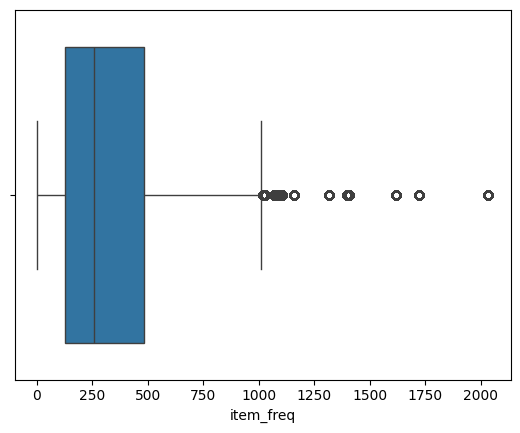

In [ ]:
# Distribution after removing item that are bought only 1 time by 1 customer, and customers who buy only has 1 purchase with 1 item (item-item logic)
pd_filter = df_filter.toPandas()
import seaborn as sns
sns.boxplot(data=pd_filter[pd_filter.item_freq > 1], x="item_freq")

In [ ]:
df_customer = df_filter.groupBy("CustomerID").agg(F.countDistinct("InvoiceNo").alias("cust_freg"), F.sum("Quantity").alias("total_quantity"))
df_customer.summary().show()

+-------+------------------+-----------------+-----------------+
|summary|        CustomerID|        cust_freg|   total_quantity|
+-------+------------------+-----------------+-----------------+
|  count|              4267|             4267|             4267|
|   mean|15290.473869228967|  4.3257558003281|1171.251699086009|
| stddev|1719.6767331491558|7.750159919066668|4808.094801203909|
|    min|           12347.0|                1|                2|
|    25%|           13809.0|                1|              165|
|    50%|           15280.0|                2|              390|
|    75%|           16770.0|                5|             1004|
|    max|           18287.0|              209|           196915|
+-------+------------------+-----------------+-----------------+



Based on the distribution in customer frequency, for this item-item context, I will split the dataset to a train set and a test set using the following logic:
For each customer with more 6 purchases (customers having 6 invoices), we retrieve their latest 3 purchases as test; for customers with less than 6 purchases, we retrieve their latest 1 purchase as test; for customers with only 1 purchase, they are remained on train set.

It is similar to leave-k validation method but as the distribution of cust_frequency is large, I use this approach to optimize for train set depends on frequency of customer. I don't set up more detailed rules due to limit storage on google colab. As this project focuses on deploying recommendation system, not machine learning, I will not do cross-validation to find the best k for train/test split.

In [ ]:
# ranking invoices order by invoicedate within each customer partition
max_invoice = df_filter.groupBy("CustomerID", "InvoiceNo").agg(F.max("InvoiceDate").alias("InvoiceDate"))
count_invoice = max_invoice.groupBy("CustomerID").agg(F.count("InvoiceNo").alias("Invoice_Cnt"))
window = Window.partitionBy("CustomerID").orderBy(col("InvoiceDate").asc(), F.monotonically_increasing_id())
rank_invoice = rank_invoice = max_invoice.withColumn("rank",
                                                     F.row_number().over(window))
rank_invoice = rank_invoice.withColumn("partition_count",
                                       F.count("*").over(Window.partitionBy("CustomerID")))

In [ ]:
# train/test split rule
df_split = rank_invoice.withColumn("keep_test", F.when(F.col("partition_count")==1, F.lit(0))
    .when(F.col("partition_count") >= 6, F.lit(3))
    .otherwise(F.lit(1))).withColumn(
        "to_test",
        F.when(
            (F.col("keep_test") > 0) & (F.col("rank") > (F.col("partition_count") - F.col("keep_test"))), F.lit(1)).otherwise(F.lit(0)))

In [ ]:
df_train = df_split.filter(F.col("to_test") == 0).drop("rank")
df_test  = df_split.filter(F.col("to_test") == 1).drop("rank")

In [ ]:
df_train.select("CustomerID").distinct().count()

4267

In [ ]:
df_test.select("CustomerID").distinct().count()

2844

In [ ]:
df_train.select("InvoiceNo").distinct().count()

13870

In [ ]:
df_test.select("InvoiceNo").distinct().count()

4588

In [ ]:
df_test.select("CustomerID").distinct().count()/df_train.select("CustomerID").distinct().count()

0.6665104288727444

In [ ]:
df_test.select("InvoiceNo").distinct().count()/df_train.select("InvoiceNo").distinct().count()

0.3307858687815429

In [ ]:
df_train = df_train.drop("Count", "partition_count", "keep_test", "to_test")
df_train = df_filter.join(df_train, on=["CustomerID", "InvoiceNo"], how='inner')
df_test = df_test.drop("Count", "partition_count", "keep_test", "to_test")
df_test = df_filter.join(df_test, on=["CustomerID", "InvoiceNo"], how='inner')

### 2.2. Build mean user-item matrix (Customer, StockCode, Rating) and Scale Data

In [ ]:
# Build user_item matrix (but flattened as a df to make calculation better)
  # Colab ran out of memories when I tried performing as vectors using Spark VectorAssembler
user_item = df_train.withColumn("log_qty", F.log(1+col("Quantity"))).groupBy("CustomerID", "StockCode").agg(
    F.countDistinct("InvoiceNo").alias("Frequency"),
    F.sum("log_qty").alias("LogQty")).withColumn("Rating", F.col("Frequency") + F.col("logQty"))
#user_item_matrix = user_item.groupBy("StockCode").pivot("CustomerID").agg(F.first("Rating")).fillna(0)

In [ ]:
user_item.select("Rating").summary().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|            210242|
|   mean| 4.132043770698473|
| stddev| 4.333774634535058|
|    min|1.6931471805599454|
|    25%|2.0986122886681096|
|    50%|3.1972245773362196|
|    75%| 4.218875824868201|
|    max|174.49566533393065|
+-------+------------------+



In [ ]:
user_item

DataFrame[CustomerID: double, StockCode: string, Frequency: bigint, LogQty: double, Rating: double]

Rating score ranges between 1 and 174, which is too sparse to measure by rmse => scale it to 1-10. I derive the formula from this source: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range

In [ ]:
def scaled_rating(df):
  current_rating = df.agg(
        F.min("Rating").alias("rmin"),
        F.max("Rating").alias("rmax")).collect()[0]
  rmin = current_rating["rmin"]
  rmax = current_rating["rmax"]
  tmin = 1
  tmax = 10
  df_scaled = df.withColumn("Rating_scaled",
    ((F.col("Rating")-rmin)/ (rmax - rmin)) * (tmax - tmin) + tmin)
  df_scaled = df_scaled.withColumn("Rating_scaled", F.round(F.col("Rating_scaled"), 3))
  df_scaled = df_scaled.drop("Rating").withColumnRenamed("Rating_scaled", "Rating")
  return df_scaled

In [ ]:
user_item = scaled_rating(user_item)

In [ ]:
# after scaled
user_item.select("Rating").summary().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|            210242|
|   mean| 1.126946000322605|
| stddev|0.2257369826471668|
|    min|               1.0|
|    25%|             1.021|
|    50%|             1.078|
|    75%|             1.132|
|    max|              10.0|
+-------+------------------+



In [ ]:
# Calculate r - rmean
row_mean = user_item.groupby("StockCode").agg(F.mean("Rating").alias("row_mean"))
flatten_matrix_with_mean = user_item.join(row_mean, on=['StockCode'], how="left")
flatten_matrix_with_mean = flatten_matrix_with_mean.withColumn("mean_rating",col("Rating")-col("row_mean"))
flatten_matrix_with_mean = flatten_matrix_with_mean.withColumn("CustomerID", col("CustomerID").cast("int").cast('string'))

### 2.3. Calculate Cosine Distince to find similar products pairs


In [ ]:
# Cosine Distance between each pair of StockCode (I use Kaz's func below but adjusted for item-item context)
df_mean = flatten_matrix_with_mean.drop("row_mean", "Rating")
df_mean = df_mean.orderBy("StockCode")
pairs = df_mean.alias("a").join(df_mean.alias("b"), (F.col("a.CustomerID") == F.col("b.CustomerID")) & (F.col("a.StockCode") < F.col("b.StockCode")))
dot_prod = pairs.groupBy("a.StockCode", "b.StockCode").agg(F.sum(F.col("a.mean_rating") * F.col("b.mean_rating")).alias("dot_prod"))
norm = df_mean.groupBy("StockCode").agg(F.sqrt(F.sum(F.col("mean_rating")**2)).alias("norm"))

sim = dot_prod.join(norm.withColumnRenamed("StockCode", "item1").withColumnRenamed("norm", "norm1"),
          dot_prod["a.StockCode"] == F.col("item1")).join(norm.withColumnRenamed("StockCode", "item2").withColumnRenamed("norm", "norm2"),
          dot_prod["b.StockCode"] == F.col("item2"))

cos_sim = sim.withColumn("cosine_similarity", F.col("dot_prod") / (F.col("norm1") * F.col("norm2"))).select(
    F.col("a.StockCode").alias("StockCode1"),
    F.col("b.StockCode").alias("StockCode2"),
    "cosine_similarity")

cosine_similarity = cos_sim.filter(F.col("cosine_similarity")>0)
similar_product = Window.partitionBy("StockCode1").orderBy(F.desc("cosine_similarity"))
# get only 3 highest similar products for each StockCode to limit Colab memory crash
similarities = (cosine_similarity.withColumn("rank", F.rank().over(similar_product)).filter(F.col("rank") <= 3))


In [ ]:
similarities.cache()

DataFrame[StockCode1: string, StockCode2: string, cosine_similarity: double, rank: int]

### 2.4. Get a recommend list for each CustomerID

In [ ]:
user_item_ls = df_mean.groupBy("CustomerID").agg(F.collect_set("StockCode").alias("purchased"))
user_item_exploded = user_item_ls.withColumn("item", F.explode("purchased"))

In [ ]:
rec_candidates = (user_item_exploded.alias("x").join(similarities.alias("y"), F.col("x.item") == F.col("y.StockCode1"))
    .select(
        F.col("x.CustomerID"),
        F.col("y.StockCode1").alias("purchased_item"),
        F.col("x.purchased"),
        F.col("y.StockCode2").alias("candidate_rec"),
        F.col("y.cosine_similarity")))

In [ ]:
# remove duplicates
rec_candidates_clean = rec_candidates.filter(~F.array_contains(F.col("purchased"), F.col("candidate_rec")))

In [ ]:
# calculate weighted rating score
rating = user_item.select("CustomerID", "StockCode", "Rating").withColumnRenamed("StockCode", "Purchased_item")
candidates_w_rating = rec_candidates.join(rating, on=["CustomerID", "Purchased_item"], how='left')
cand_with_ratings = candidates_w_rating.withColumn("weighted_rating", F.col("cosine_similarity")*F.col("Rating"))
cand_with_ratings = cand_with_ratings.groupBy("CustomerID", "Candidate_rec").agg(F.sum("weighted_rating").alias("weighted_rating"), F.sum("cosine_similarity").alias("sum_cosine"))
cand_with_ratings= cand_with_ratings.withColumn("pred_rating", F.col("weighted_rating")/F.col("sum_cosine"))

In [ ]:
cand_with_ratings.cache()

DataFrame[CustomerID: string, Candidate_rec: string, weighted_rating: double, sum_cosine: double, pred_rating: double]

In [ ]:
# final prediction
window = Window.partitionBy("CustomerID").orderBy(F.desc("pred_rating"))
rec_ls = cand_with_ratings.withColumn("rank", F.rank().over(window)).filter(F.col("rank") <= 3).select("CustomerID", "Candidate_rec", "pred_rating")

### **2.5. Evaluation**

In [ ]:
# Scale Test Rating
user_item_test = df_test.withColumn("log_qty", F.log(1+col("Quantity"))).groupBy("CustomerID", "StockCode").agg(F.countDistinct("InvoiceNo").alias("Frequency"), F.sum("log_qty").alias("LogQty")).withColumn("Rating", F.col("Frequency") + F.col("logQty"))
user_item_test_scaled = scaled_rating(user_item_test)

In [ ]:
rec_ls = rec_ls.withColumnRenamed("Candidate_rec", "StockCode")

RMSE

In [ ]:
# RMSE: sqrt(sum(predicted_score - actual_score)^2/ number of prediction)
rmse_check = rec_ls.join(user_item_test_scaled, on=["CustomerID", "StockCode"], how="left")
rmse_check = rmse_check.withColumn("numerator",(F.col("pred_rating") - F.col("Rating")) ** 2)
rmse_check = rmse_check.agg(F.sqrt(F.sum("numerator") / F.count("*")).alias("rmse"))
rmse_check.show()

+-------------------+
|               rmse|
+-------------------+
|0.20260205503948553|
+-------------------+



Precision

In [ ]:
test_actual = df_test.groupBy("CustomerID").agg(F.collect_set("StockCode").alias("actual_items"))

In [ ]:
rec_with_actual = rec_ls.join(test_actual, on="CustomerID", how="inner")
evaluated = rec_with_actual.withColumn("is_correct",F.when(F.array_contains("actual_items", F.col("StockCode")), 1).otherwise(0))
evaluated.dropDuplicates()
precision = evaluated.agg(F.sum("is_correct").alias("correct"), F.count("*").alias("total_prediction")).withColumn("precision", F.col("correct")/F.col("total_prediction"))
precision.show()

+-------+----------------+-------------------+
|correct|total_prediction|          precision|
+-------+----------------+-------------------+
|    729|           12863|0.05667418176164192|
+-------+----------------+-------------------+



Number of Customers and Products are recommended

In [ ]:
df1 = df_test.select("CustomerID").dropDuplicates().withColumn("Test_Customer", F.col("CustomerID"))
df2 = rec_ls.select("CustomerID").dropDuplicates().withColumn("Predicted_Customer", F.col("CustomerID"))
coverage = df1.join(df2, on="CustomerID", how="left").agg(F.countDistinct("Predicted_Customer").alias("TotalPred"),
                                                          F.countDistinct("Test_Customer").alias("TotalTest")
                                                          ).withColumn("coverage", F.col("TotalPred")/F.col("TotalTest"))

In [ ]:
coverage.show()

+---------+---------+------------------+
|TotalPred|TotalTest|          coverage|
+---------+---------+------------------+
|     2842|     2844|0.9992967651195499|
+---------+---------+------------------+



In [ ]:
# StockCode
df1 = df_test.select("StockCode").dropDuplicates().withColumn("Test_StockCode", F.col("StockCode"))
df2 = rec_ls.select("StockCode").dropDuplicates().withColumn("Predicted_StockCode", F.col("StockCode"))
coverage = df1.join(df2, on="StockCode", how="left").agg(F.countDistinct("Predicted_StockCode").alias("TotalPred"),
                                                          F.countDistinct("Test_StockCode").alias("TotalTest")
                                                          ).withColumn("coverage", F.col("TotalPred")/F.col("TotalTest"))

In [ ]:
coverage.show()

+---------+---------+-------------------+
|TotalPred|TotalTest|           coverage|
+---------+---------+-------------------+
|     1456|     3023|0.48164075421766456|
+---------+---------+-------------------+



## 3. User-User Recommendation System
Similar method of find recommended items as above for User-Item, just creating pairs of users, User-User.

### 3.1. Experiment Design

In [ ]:
df_item = df_clean.groupBy("StockCode").agg(F.count("*").alias("item_freq"))
df_filter = df_clean.join(df_item, on="StockCode", how="left").filter(F.col("item_freq")>1)
df_customer = df_filter.groupBy("CustomerID").agg(F.count("InvoiceNo").alias("cust_freg"), F.sum("Quantity").alias("total_quantity"))
df_filter = df_filter.join(df_customer, on ="CustomerID", how='left').filter((F.col("cust_freg")>1)&(F.col("total_quantity")>1))

df_customer = df_filter.groupBy("CustomerID").agg(F.countDistinct("InvoiceNo").alias("cust_freg"), F.sum("Quantity").alias("total_quantity"))
df_customer.summary().show()

+-------+------------------+-----------------+-----------------+
|summary|        CustomerID|        cust_freg|   total_quantity|
+-------+------------------+-----------------+-----------------+
|  count|              4267|             4267|             4267|
|   mean|15290.473869228967|  4.3257558003281|1171.251699086009|
| stddev|1719.6767331491558|7.750159919066668|4808.094801203909|
|    min|           12347.0|                1|                2|
|    25%|           13809.0|                1|              165|
|    50%|           15280.0|                2|              390|
|    75%|           16770.0|                5|             1004|
|    max|           18287.0|              209|           196915|
+-------+------------------+-----------------+-----------------+



In [ ]:
# ranking invoices order by invoicedate within each customer partition
max_invoice = df_filter.groupBy("CustomerID", "InvoiceNo").agg(F.max("InvoiceDate").alias("InvoiceDate"))
count_invoice = max_invoice.groupBy("CustomerID").agg(F.count("InvoiceNo").alias("Invoice_Cnt"))
window = Window.partitionBy("CustomerID").orderBy(col("InvoiceDate").asc(), F.monotonically_increasing_id())
rank_invoice = rank_invoice = max_invoice.withColumn("rank",
                                                     F.row_number().over(window))
rank_invoice = rank_invoice.withColumn("partition_count",
                                       F.count("*").over(Window.partitionBy("CustomerID")))

# train/test split rule
df_split = rank_invoice.withColumn("keep_test", F.when(F.col("partition_count")==1, F.lit(0))
    .when(F.col("partition_count") >= 6, F.lit(3))
    .otherwise(F.lit(1))).withColumn(
        "to_test",
        F.when(
            (F.col("keep_test") > 0) & (F.col("rank") > (F.col("partition_count") - F.col("keep_test"))), F.lit(1)).otherwise(F.lit(0)))

df_train = df_split.filter(F.col("to_test") == 0).drop("rank")
df_test  = df_split.filter(F.col("to_test") == 1).drop("rank")

In [ ]:
df_train = df_train.drop("Count", "partition_count", "keep_test", "to_test")
df_train = df_filter.join(df_train, on=["CustomerID", "InvoiceNo"], how='inner')
df_test = df_test.drop("Count", "partition_count", "keep_test", "to_test")
df_test = df_filter.join(df_test, on=["CustomerID", "InvoiceNo"], how='inner')

### 3.2 Build User-Item Matrix

In [ ]:
# Build user_item matrix (but flattened as a df to make calculation better)
  # Colab ran out of memories when I tried performing as vectors using Spark VectorAssembler
user_item = df_train.withColumn("log_qty", F.log(1+col("Quantity"))).groupBy("CustomerID", "StockCode").agg(
    F.countDistinct("InvoiceNo").alias("Frequency"),
    F.sum("log_qty").alias("LogQty")).withColumn("Rating", F.col("Frequency") + F.col("logQty"))
#user_item_matrix = user_item.groupBy("StockCode").pivot("CustomerID").agg(F.first("Rating")).fillna(0)

In [ ]:
user_item = scaled_rating(user_item)

In [ ]:
user_mean = user_item.groupBy("CustomerID").agg(F.mean("Rating").alias("user_mean"))
flatten = user_item.join(user_mean, "CustomerID")
flatten = flatten.withColumn("adj_rating", col("Rating") - col("user_mean"))

### 3.3 Calculate Cosine Distance to find similar user pairs
* Pair every two users that purchased the same items, so those that share history of purchasing contribute to similarity
* Compute cosign distance

In [ ]:
# 3. Calculate Cosine Distance finding similar user pairs
#df_mean taken from section 2.2, User-Item matrix
df_mean = flatten.drop("user_mean", "Rating")
df_mean = df_mean.orderBy("CustomerID")

#Pair users that purchased the same item
pairs = df_mean.alias("a").join(df_mean.alias("b"),(F.col("a.StockCode") == F.col("b.StockCode")) &(F.col("a.CustomerID") < F.col("b.CustomerID")))

#Compute user-user dot products to capture shared preference strength
dot_prod = pairs.groupBy("a.CustomerID", "b.CustomerID").agg(F.sum(F.col("a.adj_rating") * F.col("b.adj_rating")).alias("dot_prod"))

#Norm for each user
norm = df_mean.groupBy("CustomerID").agg(F.sqrt(F.sum(F.col("adj_rating")**2)).alias("norm"))

sim = dot_prod.join(norm.withColumnRenamed("CustomerID", "user1").withColumnRenamed("norm", "norm1"),dot_prod["a.CustomerID"] == F.col("user1")
      ).join(norm.withColumnRenamed("CustomerID", "user2").withColumnRenamed("norm", "norm2"),dot_prod["b.CustomerID"] == F.col("user2"))

cos_sim = sim.withColumn("cosine_similarity", F.col("dot_prod") / (F.col("norm1") * F.col("norm2"))
    ).select(F.col("a.CustomerID").alias("User1"),F.col("b.CustomerID").alias("User2"),"cosine_similarity")

cosine_similarity = cos_sim.filter(F.col("cosine_similarity") > 0)

#Top 3 nearest neighbors
similar_user = Window.partitionBy("User1").orderBy(F.desc("cosine_similarity"))
similarities = cosine_similarity.withColumn("rank", F.rank().over(similar_user)).filter(F.col("rank") <= 3)

similarities.cache()


In [ ]:
#Display similarities
similarities.show(truncate=False)

+-------+-------+-------------------+----+
|User1  |User2  |cosine_similarity  |rank|
+-------+-------+-------------------+----+
|12493.0|13347.0|0.3694951791140557 |1   |
|12493.0|13349.0|0.3279479344222841 |2   |
|12493.0|13995.0|0.3208913691637478 |3   |
|13094.0|15864.0|0.563747726776052  |1   |
|13094.0|16018.0|0.496580530373814  |2   |
|13094.0|13837.0|0.48070497023915193|3   |
|13533.0|16929.0|0.3318835111192298 |1   |
|13533.0|14451.0|0.3236988901853461 |2   |
|13533.0|14782.0|0.30483528656277586|3   |
|13607.0|17904.0|0.18587177320123835|1   |
|13607.0|14491.0|0.18346346877064396|2   |
|13607.0|16892.0|0.1618098634160534 |3   |
|13918.0|16583.0|0.2109742849038633 |1   |
|13918.0|18183.0|0.13251327772689084|2   |
|13918.0|15689.0|0.12771796102813376|3   |
|13956.0|15953.0|0.41146193052451246|1   |
|13956.0|15046.0|0.3790186469632384 |2   |
|13956.0|17236.0|0.3606831473000898 |3   |
|13973.0|15714.0|0.31979235584248045|1   |
|13973.0|17624.0|0.2594730802003985 |2   |
+-------+--

### 3.4 Generate list of 3 recommended item's from User-User similarities, for each user



In [ ]:
# 3. Recommendation list for each CustomerID

#Purchased items / user
user_purchases = df_mean.groupBy("CustomerID").agg(F.collect_set("StockCode").alias("purchased"))
user_exploded = user_purchases.withColumn("neighbor", F.explode("purchased"))

#Join neighbors with similar users
candidates = (similarities.alias("sim").join(user_purchases.alias("u2"), F.col("sim.User2") == F.col("u2.CustomerID")).select(
        F.col("sim.User1").alias("CustomerID"),F.col("u2.purchased").alias("neighbor_items"),F.col("sim.User2").alias("neighbor"),"sim.cosine_similarity"))

candidates = candidates.withColumn("candidate_rec", F.explode("neighbor_items"))

# Exclude items the user has previously purchased
candidates_cleaned = (candidates.join(user_purchases, "CustomerID").filter(~F.array_contains("purchased", "candidate_rec")))

#Calculate the weighted rating
rating = user_item.select("CustomerID", "StockCode", "Rating").withColumnRenamed("StockCode", "candidate_rec").alias("r")

recommendations = candidates_cleaned.alias("rc")
candidate_ratings = recommendations.join(rating,(F.col("rc.neighbor") == F.col("r.CustomerID")) &(F.col("rc.candidate_rec") == F.col("r.candidate_rec")),how="left")
candidate_ratings = candidate_ratings.withColumn("weighted_rating",F.col("cosine_similarity") * F.col("Rating"))
candidate_ratings = candidate_ratings.groupBy(F.col("rc.CustomerID").alias("CustomerID"),F.col("rc.candidate_rec").alias("candidate_rec")).agg(F.sum("weighted_rating").alias("weighted_rating"),F.sum("cosine_similarity").alias("sum_cosine"))
candidate_ratings = candidate_ratings.withColumn("pred_rating",F.col("weighted_rating") / F.col("sum_cosine"))

candidate_ratings.cache()

#Top 3 predictions
window = Window.partitionBy("CustomerID").orderBy(F.desc("pred_rating"))
recommendation_list = candidate_ratings.withColumn("rank", F.rank().over(window)).filter(F.col("rank") <= 3).select("CustomerID", "candidate_rec", "pred_rating")


In [ ]:
#Display list
recommendation_list.show(truncate=False)

+----------+-------------+------------------+
|CustomerID|candidate_rec|pred_rating       |
+----------+-------------+------------------+
|12348.0   |21213        |1.606             |
|12348.0   |21975        |1.433             |
|12348.0   |22417        |1.386             |
|12354.0   |84568        |2.037             |
|12354.0   |84596B       |1.802             |
|12354.0   |84596F       |1.7759999999999998|
|12356.0   |84991        |1.1863270319354455|
|12356.0   |21975        |1.132             |
|12356.0   |22951        |1.132             |
|12356.0   |21213        |1.132             |
|12358.0   |22127        |1.132             |
|12358.0   |22132        |1.132             |
|12358.0   |22133        |1.132             |
|12358.0   |22128        |1.132             |
|12358.0   |21232        |1.132             |
|12359.0   |22423        |2.3732304116823473|
|12359.0   |22241        |1.773             |
|12359.0   |22666        |1.758             |
|12360.0   |22328        |1.443771

### 3.5 Evaluation
* RMSE
* Precision

In [ ]:
user_user = df_test.withColumn("log_qty", F.log(1+col("Quantity"))).groupBy("CustomerID", "StockCode").agg(
    F.countDistinct("InvoiceNo").alias("Frequency"),F.sum("log_qty").alias("LogQty")).withColumn("Rating", F.col("Frequency") + F.col("LogQty"))
user_user_scaled = scaled_rating(user_user)
recommendation_list = recommendation_list.withColumnRenamed("candidate_rec", "StockCode")

In [ ]:
#RMSE
rmse_check = recommendation_list.join(user_user_scaled, on=["CustomerID", "StockCode"], how="left")
rmse_check = rmse_check.withColumn("numerator", (F.col("pred_rating") - F.col("Rating")) ** 2)
rmse_check = rmse_check.agg(F.sqrt(F.sum("numerator") / F.count("*")).alias("rmse"))

rmse_check.show()

+------------------+
|              rmse|
+------------------+
|0.4221864342126628|
+------------------+



In [ ]:
#Precision
test_actual = df_test.groupBy("CustomerID").agg(F.collect_set("StockCode").alias("actual_items"))
recommendation_with_actual = recommendation_list.join(test_actual, on="CustomerID", how="inner")
evaluated = recommendation_with_actual.withColumn("is_correct",F.when(F.array_contains("actual_items", F.col("StockCode")), 1).otherwise(0))

precision = evaluated.agg(F.sum("is_correct").alias("correct"),F.count("*").alias("total_prediction")).withColumn("precision", F.col("correct") / F.col("total_prediction"))

precision.show()

+-------+----------------+-------------------+
|correct|total_prediction|          precision|
+-------+----------------+-------------------+
|   1429|           10137|0.14096872842063726|
+-------+----------------+-------------------+



In [ ]:
#Customers
df1 = df_test.select("CustomerID").dropDuplicates().withColumn("Test_Customer", F.col("CustomerID"))
df2 = recommendation_list.select("CustomerID").dropDuplicates().withColumn("Predicted_Customer", F.col("CustomerID"))
coverage = df1.join(df2, on="CustomerID", how="left").agg(F.countDistinct("Predicted_Customer").alias("TotalPred"),F.countDistinct("Test_Customer").alias("TotalTest")).withColumn("CustomerCoverage", F.col("TotalPred")/F.col("TotalTest"))

coverage.show()

+---------+---------+------------------+
|TotalPred|TotalTest|  CustomerCoverage|
+---------+---------+------------------+
|     2781|     2844|0.9778481012658228|
+---------+---------+------------------+



In [ ]:
#StockCode
df1 = df_test.select("StockCode").dropDuplicates().withColumn("Test_StockCode", F.col("StockCode"))
df2 = recommendation_list.select("StockCode").dropDuplicates().withColumn("Predicted_StockCode", F.col("StockCode"))
coverage = df1.join(df2, on="StockCode", how="left").agg(F.countDistinct("Predicted_StockCode").alias("TotalPred"),F.countDistinct("Test_StockCode").alias("TotalTest")).withColumn("StockCodeCoverage", F.col("TotalPred")/F.col("TotalTest"))

coverage.show()

+---------+---------+------------------+
|TotalPred|TotalTest| StockCodeCoverage|
+---------+---------+------------------+
|     1375|     3023|0.4548461792920939|
+---------+---------+------------------+

